# Final Project: Pitchfork Album Score Prediction

We are attempting to classify pitchfork album reviews by using multiple machine learning methods for Sentiment Analysis. We started by using a Naive Bayes Model, similar to HW03, to classify album reviews as either neutral or positive. Unsurprisingly, it did not perform that well, mainly due to the fact that pitchfork reviews use a higher level of vocabulary and more complex sentence structure than an average yelp review (as seen in hw03). So we used the results from the Naive Bayes model as a baseline to compare against. We then attempted to train an SVM on our data for sentiment analysis. After tweaking the parameters, we were able to achieve a somewhat decent accuracy. 

**To run this code, press Run all in Google Colab.**

## The Domain
Our domain was album reviews from the website [Pitchfork](https://pitchfork.com/) - the self acclaimed 'most trusted voice in music'. Pitchfork is known for their critical reviews that can make or break careers. Their reviews are known for their flowery, superfluous language which makes it more difficult to perform sentiment analysis on. 

## The Data

We obtained our data from [Kaggle](https://www.kaggle.com/nolanbconaway/pitchfork-data). Kaggle user Nolan Conaway conveniently scraped and compiled this data from [Pitchfork reviews](https://pitchfork.com/reviews/albums/). He scraped data starting from Jan 5, 1999 to Jan 8, 2017. This gave us album review data spanning over 18 years, which yielded 18,401 rows of data - more than enough for most machine learning applications. 

In [1]:
import pandas as pd
raw_df = pd.read_csv('https://raw.githubusercontent.com/neelchoudhary/pitchfork_sentiment_analysis/master/data.csv', engine='python')

In [2]:
raw_df.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,reviewid.1,content
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017,22703,"“Trip-hop” eventually became a ’90s punchline,..."
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017,22721,"Eight years, five albums, and two EPs in, the ..."
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,22659,Minneapolis’ Uranium Club seem to revel in bei...
3,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,22661,Kleenex began with a crash. It transpired one ...
4,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017,22725,It is impossible to consider a given release b...


## Data Cleaning
As seen in the raw data, there are many columns that are not needed for sentiment analysis. There are also too many possibilities for the score, so we rounded each score to the nearest integer. The following code block rounds the score and drops unnecessary columns.

In [3]:
rounded_df = raw_df.round({'score': 0})
df = rounded_df.drop(columns=['best_new_music', 'pub_weekday', 'pub_day', 'pub_month', 'pub_year', 'author_type', 'reviewid.1', 'author', 'pub_date', 'url', 'artist', 'title']).dropna()
df.head()

,reviewid,score,content
0,22703,9.0,"“Trip-hop” eventually became a ’90s punchline,..."
1,22721,8.0,"Eight years, five albums, and two EPs in, the ..."
2,22659,7.0,Minneapolis’ Uranium Club seem to revel in bei...
3,22661,9.0,Kleenex began with a crash. It transpired one ...
4,22725,8.0,It is impossible to consider a given release b...


## Data Visualization
We analyzed the score distribution of our data in order to figure out the best way to cull / transform our data in order to make it more balanced. This is to avoid issues with overfitting to a certain score that is more prevelant than the other scores. 

###Score distribution graph using Seaborn
As seen below, the score is heavily skewed towards the 7-8 range. This is problematic as there is very little data at the tails, especially the left tail of this distribution. 

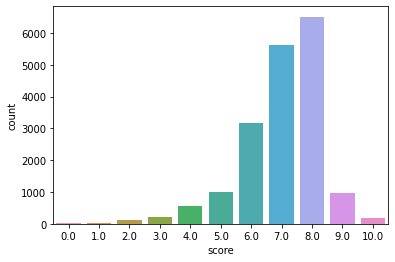

In [4]:
import seaborn as sns
sns.countplot(x=df.score)

Given these results, we decided to cull data with a rounded score less than 5. We then decided to consolidate the scores 5-7 into the neutral category (0), and the scores 8-10 in the positive category (1). 

In [5]:
def score_transform(rating):
  rating = float(rating)
  if rating < 5:
    return -1 # negative
  if rating >= 5 and rating <= 7:
    return 0 # neutral
  else:
    return 1 # positive

df_final = df.copy(deep=True)
df_final['score'] = df['score'].apply(score_transform)
df_final = df_final[df_final['score'] != -1]

In [6]:
df_final.head()

,reviewid,score,content
0,22703,1,"“Trip-hop” eventually became a ’90s punchline,..."
1,22721,1,"Eight years, five albums, and two EPs in, the ..."
2,22659,0,Minneapolis’ Uranium Club seem to revel in bei...
3,22661,1,Kleenex began with a crash. It transpired one ...
4,22725,1,It is impossible to consider a given release b...


The tranformed data is more balanced, as seen below.

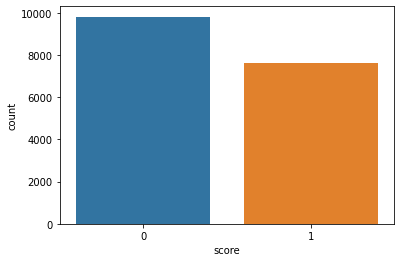

In [7]:
sns.countplot(x=df_final.score)

## Features, Targets, and Data Splitting
We split our data into three datasets for training, testing, and validation. We used a 60/20/20 split respectively. 

In [8]:
features = df_final.drop(columns='score')
targets = df_final['score']

In [9]:
features.head()

,reviewid,content
0,22703,"“Trip-hop” eventually became a ’90s punchline,..."
1,22721,"Eight years, five albums, and two EPs in, the ..."
2,22659,Minneapolis’ Uranium Club seem to revel in bei...
3,22661,Kleenex began with a crash. It transpired one ...
4,22725,It is impossible to consider a given release b...


In [10]:
targets.head()

0    1
1    1
2    0
3    1
4    1
Name: score, dtype: int64

In [11]:
from sklearn.model_selection import train_test_split
features_trainvalidation, features_test, targets_trainvalidation, targets_test = train_test_split(features, targets, train_size=0.8, random_state=4100)
features_train, features_validation, targets_train, targets_validation = train_test_split(features_trainvalidation, targets_trainvalidation, train_size=0.75, random_state=4100)

In [12]:
training_df = features_train.copy(deep=True)
training_df['score'] = targets_train
training_df.head()

,reviewid,content,score
9772,12187,So an MC who's been recording for over a decad...,1
6120,15928,There's been no shortage of dialogue around ho...,1
5105,17154,"On the last day of November 2010, Bonnie ""Prin...",1
16716,6226,"In the liner notes for O.S.T., People Under th...",1
9035,12949,Unlike his predecessors in the fraternal orde...,0


In [13]:
validation_df = features_validation.copy(deep=True)
validation_df['score'] = targets_validation
validation_df.head()

,reviewid,content,score
3581,18705,The worst thing about the remarkable The First...,1
721,21872,"Try as they might, Mourn couldn’t help but sho...",0
12685,7729,"On paper, The Seeger Sessions seems like a ter...",1
10816,10754,\r\n Getting the full picture of Joe Willia...,1
16114,5031,"Friends Forever isn't a metal record, but let'...",0


In [14]:
test_df = features_test.copy(deep=True)
test_df['score'] = targets_test
test_df.head()

,reviewid,content,score
402,22212,The hippies inspired a wholesale revision of m...,1
1439,21143,VHÖL are the ideal modern metal band—they fuse...,1
7035,14995,Sic Alps' simple garage-rock is both enticing ...,1
12078,9538,While it's nice to hear Mac McCaughan hearken ...,1
17236,223,Stop me if this gets sappy. And it might. Beca...,1


## Naive Bayes & Markov Model
As a baseline, we used the naive bayes & markov model from HW03 to classify sentiments in our dataset. We modified to code to classify between a neutral and positive sentiment. We used bigrams for the Markov Model. We hypothesized that while both models would perform poorly on this dataset, the markov model would perform slightly better. This is because these album reviews are highly dependent on context, therefore, using bigrams would result in slightly higher performance. 

Code attribution from HW03. Modified to fit our dataset. 

In [15]:
from nltk.util import bigrams

def tokenize(sentence):
    """ Returns list of tokens (strings) from the sentence.

    Sets to lowercase and separates tokens by whitespace.

    Args:
        sentence (string):  the string to tokenize
    """
    return [t.lower() for t in sentence.split()]

class ModelInfo:
    """ Contains all counts from the data necessary to do Naive Bayes.

    Attributes:
        word_counts (List[Dict[string,int]]):  counts of tokens, indexed by class
        bigram_counts (List[Dict[string,int]]): as word_counts, but for bigrams
        sentiment_counts (List[int]):  counts of sentences with each sentiment
        total_words (List[int]):  counts of words in each sentiment
        bigram_denoms (List[Dict[string,int]]):  counts of how often a token starts a bigram,
                                                 again one per sentiment.
        total_bigrams (List[int]): counts of total bigrams for each sentiment
        total_examples (int):  total sentence count
    """

    def __init__(self):
        self.word_counts = [{}, {}]
        self.bigram_counts = [{}, {}]
        self.sentiment_counts = [0, 0]
        self.total_words = [0, 0]
        self.bigram_denoms = [{}, {}]
        self.total_bigrams = [0, 0]
        self.total_examples = 0

    def __str__(self):
        words = self.total_words
        sentiments = self.sentiment_counts
        return "words by sentiment: {} sentences: {}".format(words, sentiments)

    def update_word_counts(self, sentence, sentiment):
        """ Consume a sentence and update all counts.

        To "tokenize" the sentence we'll make use of NLTK, a widely-used Python natural language
        processing (NLP) library.  This will handle otherwise onerous tasks like separating periods
        from their attached words.  (Unless the periods are decimal points ... it's more complex
        than you might think.)  The result of tokenization is a list of individual strings that are
        words or their equivalent.

        Args:
            sentence (string):  The example sentence.
            sentiment (int):  The sentiment label.
        """

        # Get the relevant dicts for the sentiment
        s_word_counts = self.word_counts[sentiment]
        s_bigram_counts = self.bigram_counts[sentiment]
        s_bigram_denoms = self.bigram_denoms[sentiment]
        tokens = tokenize(sentence)
        for token in tokens:
            self.total_words[sentiment] += 1
            s_word_counts[token] = s_word_counts.get(token, 0) + 1
        my_bigrams = bigrams(tokens)
        for bigram in my_bigrams:
            s_bigram_counts[bigram] = s_bigram_counts.get(bigram, 0) + 1
            s_bigram_denoms[bigram[0]] = s_bigram_denoms.get(bigram[0], 0) + 1
            self.total_bigrams[sentiment] += 1
       
def get_models(df):
    """Returns a model_info object, consuming dataframe for examples."""
    last_fresh = 0
    info = ModelInfo()
    for idx, line in df.iterrows():
        try:
            sentence_num = int(idx)
            # if sentence_num <= last_fresh:
                # continue
            last_fresh = sentence_num
            sentiment = int(line['score'])
            info.sentiment_counts[sentiment] += 1
            info.total_examples += 1
            info.update_word_counts(line['content'], sentiment)
        except ValueError:
            # Some kind of bad input?  Unlikely with our provided data
            continue
    return info

In [16]:
model = get_models(training_df)
print(model)

words by sentiment: [3550755, 3282454] sentences: [5878, 4591]


Code attribution from HW03. Modified to fit our dataset. 

In [17]:
""" Doing some Naive Bayes and Markov Models to do basic sentiment analysis.

Format is PhraseID[unused]   SentenceID  Sentence[tokenized] Sentiment

We'll only use the first line for each SentenceID, since the others are
micro-analyzed phrases that would just mess up our counts.

Sentiment is on a 2-point scale:
0 - neutral
1 - positive

For each kind of model, we'll build one model per sentiment category.
Following Bayesian logic, base rates matter for each category; if critics
are often negative, that should be a good guess in the absence of other
information.

Training input is assumed to be in a file called "train.tsv"

Test sentences are received via stdin (thus either interactively or with input redirection).
Output for each line of input is the following:

Naive Bayes classification (0-4)
Naive Bayes most likely class's log probability (with default double digits/precision)
Markov Model classification (0-4)
Markov Model most likely class's log probability
"""

import sys
import math

CLASSES = 2
# Assume sentence numbering starts with this number in the file

# Probability of either a unigram or bigram that hasn't been seen -
# needs to be small enough that it's "practically a rounding error"
OUT_OF_VOCAB_PROB = 0.0000000001


def naive_bayes_classify(info, sentence):
    """ Use a Naive Bayes model to return sentence's most likely classification and the log prob.

    The log probability should be base e (natural log).

    Args:
        info (ModelInfo):  a ModelInfo containing the counts from the training data
        sentence (string):  the test sentence to classify
    
    Returns:
        int for the best sentiment
        float for the best log probability (unscaled, just ln(prior * product of cond. probs))
    """

    logSentimentProb = []
    totalWords = sum(info.sentiment_counts)
    for tokenizedTotalWords in info.sentiment_counts:
      logSentimentProb.append(math.log(tokenizedTotalWords / totalWords))

    for word in tokenize(sentence):
      for index, tokenizedWordCount in enumerate(info.word_counts):
        if word in tokenizedWordCount:
          logSentimentProb[index] += math.log(tokenizedWordCount.get(word) / info.sentiment_counts[index])
        else:
          logSentimentProb[index] += math.log(OUT_OF_VOCAB_PROB)

    maxLogVal = logSentimentProb[0]
    maxLogIndex = 0;
    for index, logSentiment in enumerate(logSentimentProb):
      if logSentiment > maxLogVal:
        maxLogVal = logSentiment
        maxLogIndex = index
 
    best_class = maxLogIndex
    best_log_prob = max(logSentimentProb)
    return best_class, best_log_prob


def markov_model_classify(info, sentence):
    """ Like naive_bayes_classify, but use a bigram model for the evidence.

    The first word should still use a unigram probability to get started.
    Notice the existence of bigram_denoms, which has very slight differences from word_counts.
    Log probability is again base e.

    Args:
        info (ModelInfo):  a ModelInfo containing the counts from the training data
        sentence (string):  the test sentence to classify

    Returns:
        int for the best sentiment
        float for the best log probability (unscaled, just ln(prior * product of cond. probs))
    """

    logSentimentProb = []
    totalWords = sum(info.sentiment_counts)
    for tokenizedTotalWords in info.sentiment_counts:
      logSentimentProb.append(math.log(tokenizedTotalWords / totalWords))

    firstWord = tokenize(sentence)[0]
    for index, tokenizedWordCount in enumerate(info.word_counts):
      if firstWord in tokenizedWordCount:
        logSentimentProb[index] += math.log(tokenizedWordCount.get(firstWord) / info.sentiment_counts[index])
      else:
        logSentimentProb[index] += math.log(OUT_OF_VOCAB_PROB)

    prevWord = firstWord
    for idx, word in enumerate(tokenize(sentence)):
      if (idx != 0):
        for index, tokenizedBigramCount in enumerate(info.bigram_counts):
          bigramTuple = (prevWord, word)
          if bigramTuple in tokenizedBigramCount:
            logSentimentProb[index] += math.log(tokenizedBigramCount.get(bigramTuple) / info.bigram_denoms[index].get(prevWord))
          else:
            logSentimentProb[index] += math.log(OUT_OF_VOCAB_PROB)
        prevWord = word

    maxLogVal = logSentimentProb[0]
    maxLogIndex = 0;
    for index, logSentiment in enumerate(logSentimentProb):
      if logSentiment > maxLogVal:
        maxLogVal = logSentiment
        maxLogIndex = index

    best_class = maxLogIndex
    best_log_prob = maxLogVal
    return best_class, best_log_prob

### Error functions for accuracy prediction
We created error functions for the bayes and markov model to return the error between how the classifier classified the review, and the actual score given to the review. We then iterated through the validation data and summed up the error to find the overall accuracy. We used this for fine-tuning our hyperparameters. 

In [18]:
def error_function_bayes(model, review_content, real_score):
  predicted_score = naive_bayes_classify(model, review_content)[0]
  diff = abs(predicted_score - real_score)
  return diff

In [19]:
def error_function_markov(model, review_content, real_score):
  predicted_score = markov_model_classify(model, review_content)[0]
  diff = abs(predicted_score - real_score)
  return diff

In [34]:
total_err = 0
count = 0
for index, row in test_df.iterrows():
  count += 1
  total_err += error_function_bayes(model, row['content'], row['score'])

print("Accuracy: " + str(1 - (total_err / count)))

Accuracy: 0.5117478510028654


In [35]:
total_err = 0
count = 0
for index, row in test_df.iterrows():
  count += 1
  total_err += error_function_markov(model, row['content'], row['score'])

print("Accuracy: " + str(1 - (total_err / count)))

Accuracy: 0.6246418338108882


### Results: 
The accuracy for Naive Bayes was 0.512.

The accuracy for the Markov Model was 0.625

Unsurprisingly, both models performed poorly on our dataset. This was just to get a baseline.

## SVM Sentiment Analysis

In [22]:
def to_sentiment(rating):
  rating = float(rating)
  if rating < 5:
    return "neg"
  if rating >= 5 and rating <= 7:
    return "neu"
  else:
    return "pos"

In [23]:
svmData_raw = training_df.copy(deep=True)
svmData_indexed = svmData_raw.reset_index()
svmData_train = svmData_indexed.drop(columns=['reviewid', 'index'])
svmData_train.head()

,content,score
0,So an MC who's been recording for over a decad...,1
1,There's been no shortage of dialogue around ho...,1
2,"On the last day of November 2010, Bonnie ""Prin...",1
3,"In the liner notes for O.S.T., People Under th...",1
4,Unlike his predecessors in the fraternal orde...,0


In [24]:
svmData_raw_validation = validation_df.copy(deep=True)
svmData_indexed_validation = svmData_raw_validation.reset_index()
svmData_validation = svmData_indexed_validation.drop(columns=['reviewid', 'index'])
svmData_validation.head()

,content,score
0,The worst thing about the remarkable The First...,1
1,"Try as they might, Mourn couldn’t help but sho...",0
2,"On paper, The Seeger Sessions seems like a ter...",1
3,\r\n Getting the full picture of Joe Willia...,1
4,"Friends Forever isn't a metal record, but let'...",0


In [25]:
svmData_raw_test = test_df.copy(deep=True)
svmData_indexed_test = svmData_raw_test.reset_index()
svmData_test = svmData_indexed_test.drop(columns=['reviewid', 'index'])
svmData_test.head()

,content,score
0,The hippies inspired a wholesale revision of m...,1
1,VHÖL are the ideal modern metal band—they fuse...,1
2,Sic Alps' simple garage-rock is both enticing ...,1
3,While it's nice to hear Mac McCaughan hearken ...,1
4,Stop me if this gets sappy. And it might. Beca...,1


In [26]:
# Inspired from https://medium.com/@vasista/sentiment-analysis-using-svm-338d418e3ff1
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report

def svm_model(vectorizer, data):
  train_matrix = vectorizer.fit_transform(svmData_train['content'])
  test_matrix = vectorizer.transform(svmData_validation['content'])

  classifier_rbf = svm.SVC(kernel='rbf')
  classifier_rbf.fit(train_matrix, svmData_train['score'])
  prediction_rbf = classifier_rbf.predict(test_matrix)

  report = classification_report(svmData_validation['score'], prediction_rbf, output_dict=True)
  print('Positive Accuracy: ', report['1']['precision'])
  print('Neutral Accuracy: ', report['0']['precision'])
  return report

### Hyperparameter Tuning

In [28]:
v1 = TfidfVectorizer(min_df = 5, max_df = 0.8, sublinear_tf = True, use_idf = True)
v2 = TfidfVectorizer(min_df = 5, max_df = 0.8, sublinear_tf = False, use_idf = True)
v3 = TfidfVectorizer(min_df = 5, max_df = 0.8, sublinear_tf = True, use_idf = False)
v4 = TfidfVectorizer(min_df = 5, max_df = 0.8, sublinear_tf = False, use_idf = False)
r1 = svm_model(v1, svmData_validation['content'])
r2 = svm_model(v2, svmData_validation['content'])
r3 = svm_model(v3, svmData_validation['content'])
r4 = svm_model(v4, svmData_validation['content'])

Positive Accuracy:  0.7201336675020885
Neutral Accuracy:  0.7112952464020933
Positive Accuracy:  0.7077189939288812
Neutral Accuracy:  0.6970474967907574
Positive Accuracy:  0.6979969183359014
Neutral Accuracy:  0.718065693430657
Positive Accuracy:  0.6866614048934491
Neutral Accuracy:  0.7058029689608637


From these results, it is evident that sublinear=True and use_idf=True are the ideal settings for these two parameters. 

In [29]:
v5 = TfidfVectorizer(min_df = 5, max_df = 0.9, sublinear_tf = True, use_idf = True)
v6 = TfidfVectorizer(min_df = 5, max_df = 0.7, sublinear_tf = True, use_idf = True)
r5 = svm_model(v5, svmData_validation['content'])
r6 = svm_model(v6, svmData_validation['content'])

Positive Accuracy:  0.7226890756302521
Neutral Accuracy:  0.711304347826087
Positive Accuracy:  0.7265100671140939
Neutral Accuracy:  0.7136640557006092


From these results, it is evident that 0.7 is the ideal setting for the max_df parameter. 

In [30]:
v7 = TfidfVectorizer(min_df = 4, max_df = 0.7, sublinear_tf = True, use_idf = True)
v8 = TfidfVectorizer(min_df = 6, max_df = 0.7, sublinear_tf = True, use_idf = True)
r7 = svm_model(v7, svmData_validation['content'])
r8 = svm_model(v8, svmData_validation['content'])

Positive Accuracy:  0.7264309764309764
Neutral Accuracy:  0.712858384013901
Positive Accuracy:  0.7272727272727273
Neutral Accuracy:  0.7154081187254474


From these results, its is evident that 6 is the ideal setting for the min_df parameter. 

After hyperparameter tuning, the most optimal parameters are the following: 

  TfidfVectorizer(min_df = 6,
                               max_df = 0.7,
                               sublinear_tf = True,
                               use_idf = True)

In [31]:
optimal_vectorizer = TfidfVectorizer(min_df = 6, max_df = 0.7, sublinear_tf = True, use_idf = True)
r_optimal = svm_model(optimal_vectorizer, svmData_validation['content'])

Positive Accuracy:  0.7272727272727273
Neutral Accuracy:  0.7154081187254474


### Test Results
After tuning the hyperparameters, we concluded the most optimal parameters are min_df = 5, max_df = 0.7, sublinear_tf = True, use_idf = True, and lowercase=True. 

We achieved the following accuracies: 


Positive Accuracy:  0.727

Neutral Accuracy:  0.715

In [33]:
r_optimal = svm_model(optimal_vectorizer, svmData_test['content'])

Positive Accuracy:  0.7272727272727273
Neutral Accuracy:  0.7154081187254474


The SVM performed significantly better than the Naive Bayes & Markov Model. With an average accuracy of 0.721 vs 0.512 and 0.625 for Naive Bayes & Markov Model, respectively.

## LSTM
We tried to implement an LSTM based of this article: 
https://towardsdatascience.com/sentiment-analysis-using-lstm-step-by-step-50d074f09948

However, it was too slow to run through our data set. 


In [ ]:
import io
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from collections import Counter
import string
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split


raw_df = pd.read_csv('data.csv')

raw_df = raw_df.dropna()
raw_df['content'] = raw_df['content'].str.lower()
from string import punctuation

raw_df['content'] = raw_df['content'].str.replace('[{}]'.format(string.punctuation), '')

review_list = raw_df['content'].tolist()

train_on_gpu = False


# tokenize labels
labels = raw_df['score'].round()
encoded_labels = labels.values

# tokenize
from collections import Counter

print(len(review_list))
all_words = ' '.join(review_list)
words = all_words.split()

count_words = Counter(words)

total_words = len(words)
sorted_words = count_words.most_common(total_words)
print(sorted_words[:10])
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

# create encoding of reviews
reviews_int = []
for review in review_list:
    r = [vocab_to_int[w] for w in review.split()]
    reviews_int.append(r)
print(reviews_int[0:3])
print(review_list[0])


def pad_features(reviews_int, seq_length):
    features = np.zeros((len(reviews_int), seq_length), dtype=int)

    for i, review in enumerate(reviews_int):
        review_len = len(review)

        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length - review_len))
            new = zeroes + review
        elif review_len > seq_length:
            new = review[0:seq_length]

        features[i, :] = np.array(new)

    return features

features = pad_features(reviews_int, 200)

split_frac = 0.8
len_feat = len(features)
train_x = features[0:int(split_frac*len_feat)]
train_y = encoded_labels[0:int(split_frac*len_feat)]
remaining_x = features[int(split_frac*len_feat):]
remaining_y = encoded_labels[int(split_frac*len_feat):]
valid_x = remaining_x[0:int(len(remaining_x)*0.5)]
valid_y = remaining_y[0:int(len(remaining_y)*0.5)]
test_x = remaining_x[int(len(remaining_x)*0.5):]
test_y = remaining_y[int(len(remaining_y)*0.5):]

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
x = torch.from_numpy(test_x)
y = torch.from_numpy(test_y)
batch_size = 50
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)


class SentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=drop_prob, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]  # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

        return hidden

# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2
net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)


# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)


# training params

epochs = 4 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 1
clip=5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        inputs = inputs.type(torch.LongTensor)
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        print(counter)
        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                inputs = inputs.type(torch.LongTensor)
                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))